In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn import model_selection

import numpy as np
np.set_printoptions(suppress=True)

import warnings
warnings.filterwarnings('ignore')

**Задание 3 [опция].** Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [2]:
# сгенерируем данные

X, y, coef = datasets.make_regression(n_samples=5000, n_features=2, n_informative=2,
                                      n_targets=1, noise=10, coef=True, random_state=42)

coef

array([10.30191944, 32.12551734])

In [3]:
def calc_std_feat(x: np.array): # функция стандартизации данных
    return (x - x.mean(axis=0)) / x.std(axis=0)

In [4]:
X = calc_std_feat(X)

In [5]:
X.mean(axis=0), X.std(axis=0)

(array([0., 0.]), array([1., 1.]))

In [6]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [7]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        prediction = np.mean(self.labels)
        return prediction        

In [8]:
def variance(labels):
    return np.var(labels)

In [9]:
# Расчет качества

def quality(left_labels, right_labels, current_var):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_var - p * variance(left_labels) - (1 - p) * variance(right_labels)

In [10]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [11]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_leaf): #  обозначим минимальное количество объектов в узле

    current_var = variance(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            
            #  пропускаем разбиения, в которых в узле остается менее min_leaf объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_var)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [12]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, max_depth=50, min_samples=2, min_leaf=5):

    quality, t, index = find_best_split(data, labels, min_leaf)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)
    
    # глубина дерева
    if max_depth == 0:
        return Leaf(data, labels)
    
    # минимальное количество признаков
    if len(data) <= min_samples:
        return Leaf(data, labels)
        
  
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    
    max_depth -= 1

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, max_depth)
    false_branch = build_tree(false_data, false_labels, max_depth)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [13]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [14]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [15]:
# Разобьем выборку на обучающую и тестовую

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(X, y, test_size = 0.3, random_state = 1)

In [16]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

In [17]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
# print_tree(my_tree)

In [18]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [19]:
# И получим ответы для тестовой выборки
test_answers = predict(test_data, my_tree)

In [20]:
def calc_mse(y, y_pred): # функция вычисления среднеквадратичной ошибки
    return np.mean(np.square(y - y_pred))

In [21]:
calc_mse(train_labels, train_answers), calc_mse(test_labels, test_answers)

(61.27400888832432, 142.26841636598746)

In [22]:
def calc_R2(y, y_pred): # функция вычисления коэффициента детерминации
    return 1 - np.sum(np.square(y - y_pred)) / np.sum(np.square(y - y.mean()))

In [23]:
calc_R2(train_labels, train_answers), calc_R2(test_labels, test_answers)

(0.9507918055258214, 0.8870257519913793)

Посмотрим зависимость коэффициента детерминации от глубины дерева:

In [24]:
def my_tree(train_data, train_labels, max_depth, min_samples, min_leaf):
    
    my_tree = build_tree(train_data, train_labels, max_depth, min_samples, min_leaf) 
    train_answers = predict(train_data, my_tree)
    test_answers = predict(test_data, my_tree)
    train_accuracy = calc_R2(train_labels, train_answers)
    test_accuracy = calc_R2(test_labels, test_answers)

    return my_tree, train_accuracy, test_accuracy

In [25]:
def plot_test_calc(test_labels, test_answers, test_accuracy):
    plt.figure(figsize=(10, 10))
    plt.scatter(test_labels, test_answers, s=7)
    plt.title(f'R2 на тестовой выборке = {test_accuracy}')
    plt.grid()

In [26]:
for depth in [2, 4, 6, 7, 8, 9, 10, 15, 30, 50]:
    current_tree, train_accuracy, test_accuracy = my_tree(train_data, train_labels, max_depth=depth, min_samples=2, min_leaf=5)

    print(f'Глубина дерева: {depth}, R2 на тренировочной выборке = {train_accuracy:.4f}, ' 
          f'R2 на тестовой выборке = {test_accuracy:.4f}')

Глубина дерева: 2, R2 на тренировочной выборке = 0.7377, R2 на тестовой выборке = 0.7492
Глубина дерева: 4, R2 на тренировочной выборке = 0.8697, R2 на тестовой выборке = 0.8668
Глубина дерева: 6, R2 на тренировочной выборке = 0.9168, R2 на тестовой выборке = 0.9005
Глубина дерева: 7, R2 на тренировочной выборке = 0.9269, R2 на тестовой выборке = 0.9058
Глубина дерева: 8, R2 на тренировочной выборке = 0.9340, R2 на тестовой выборке = 0.9032
Глубина дерева: 9, R2 на тренировочной выборке = 0.9402, R2 на тестовой выборке = 0.8979
Глубина дерева: 10, R2 на тренировочной выборке = 0.9448, R2 на тестовой выборке = 0.8912
Глубина дерева: 15, R2 на тренировочной выборке = 0.9508, R2 на тестовой выборке = 0.8870
Глубина дерева: 30, R2 на тренировочной выборке = 0.9508, R2 на тестовой выборке = 0.8870
Глубина дерева: 50, R2 на тренировочной выборке = 0.9508, R2 на тестовой выборке = 0.8870


Лучшие результаты R2 на тестовой выборке получаются при глубине дерева 7 узлов.

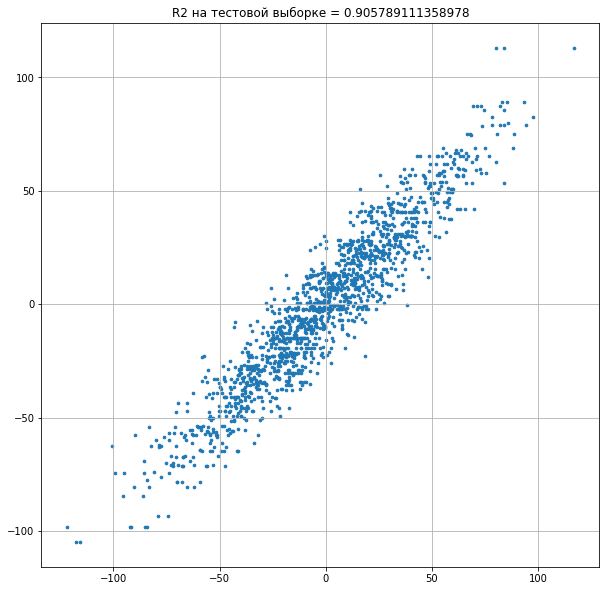

In [27]:
current_tree, train_accuracy, test_accuracy = my_tree(train_data, train_labels, max_depth=7, min_samples=2, min_leaf=5)

plot_test_calc(test_labels, test_answers, test_accuracy)